Date
2010-01-04    17558.730469
2010-01-05    17686.240234
2010-01-06    17701.130859
2010-01-07    17615.720703
2010-01-08    17540.289062
Name: Close, dtype: float64


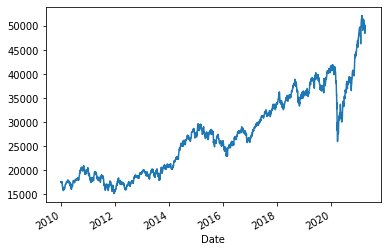

In [ ]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
import os

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
tf.random.set_seed(0)

#df_train = pdr.DataReader('^BSESN', start='2010-01-01', end='2020-09-30', data_source='yahoo')
#df_test = pdr.DataReader('^BSESN', start='2020-10-01', end='2021-03-31', data_source='yahoo')
all_data = pdr.DataReader('^BSESN', start='2010-01-01', end='2021-03-31', data_source='yahoo')
#training_set = (df_train['Close'].values).reshape(-1, 1)
#testing_set = (df_test['Close'].values).reshape(-1, 1)
#all_data = pd.concat([df_train, df_test], axis=0)
#all_data.index = pd.to_datetime(all_data.index)

print(all_data["Close"].head())
all_data["Close"].plot();

# Train-Test Split

In [ ]:
print("There are "+ str(all_data[:'2017-01']["Close"].shape[0]) + " observations in the training data 1")
print("There are "+ str(all_data['2017-02':'2020-09']["Close"].shape[0]) + " observations in the training data 2")
print("There are "+ str(all_data['2020-10':]["Close"].shape[0]) + " observations in the test data")

There are 1738 observations in the training data 1
There are 901 observations in the training data 2
There are 123 observations in the test data


In [ ]:
def ts_train_test_no_split(all_data,time_steps,for_periods,do_norm=False):
    # create training and test set
    ts_train = (all_data[:'2020-09'])['Close'].values.reshape(-1,1)
    ts_test  = (all_data['2020-10':])['Close'].values.reshape(-1,1)
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # scale the data
    if do_norm == True:
      from sklearn.preprocessing import MinMaxScaler
      sc = MinMaxScaler(feature_range=(0,1))
      ts_train_scaled = sc.fit_transform(ts_train)
    else:
      ts_train_scaled = ts_train.copy()
    ts_train_scaled.reshape(-1,1)
    # create training data of t time steps (window_size)
    X_train = []
    y_train = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = all_data["Close"].values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:] #selecting test data
    inputs = inputs.reshape(-1,1)
    if do_norm == True:
      sc = MinMaxScaler(feature_range=(0,1))
      inputs  = sc.fit_transform(inputs)
    else:
      sc = None

    # Preparing X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, sc


In [ ]:
def ts_train_test(all_data,time_steps,for_periods,do_norm=False):
    # create training and test set
    ts_train_1 = (all_data[:'2017-01'])['Close'].values.reshape(-1,1)
    ts_train_2 = (all_data['2017-02':'2020-09'])['Close'].values.reshape(-1,1)
    ts_test_1 = ts_train_2.copy()
    ts_test_2  = (all_data['2020-10':])['Close'].values.reshape(-1,1)
    ts_train_1_len = len(ts_train_1)
    ts_train_2_len = len(ts_train_2)
    ts_test_1_len = len(ts_train_2)
    ts_test_2_len = len(ts_test_2)

    # scale the data
    if do_norm == True:
      from sklearn.preprocessing import MinMaxScaler
      sc = MinMaxScaler(feature_range=(0,1))
      ts_train_scaled_1 = sc.fit_transform(ts_train_1)
    else:
      ts_train_scaled_1 = ts_train_1.copy()
    ts_train_scaled_1.reshape(-1,1)

    if do_norm == True:
      from sklearn.preprocessing import MinMaxScaler
      sc = MinMaxScaler(feature_range=(0,1))
      ts_train_scaled_2 = sc.fit_transform(ts_train_2)
    else:
      ts_train_scaled_2 = ts_train_2.copy()
    ts_train_scaled_2.reshape(-1,1)

    # create training data of t time steps
    X_train_1 = []
    y_train_1 = []
    for i in range(time_steps,ts_train_1_len-1): 
        X_train_1.append(ts_train_scaled_1[i-time_steps:i,0])
        y_train_1.append(ts_train_scaled_1[i:i+for_periods,0])
    X_train_1, y_train_1 = np.array(X_train_1), np.array(y_train_1)

    X_train_2 = []
    y_train_2 = []
    for i in range(time_steps,ts_train_2_len-1): 
        X_train_2.append(ts_train_scaled_2[i-time_steps:i,0])
        y_train_2.append(ts_train_scaled_2[i:i+for_periods,0])
    X_train_2, y_train_2 = np.array(X_train_2), np.array(y_train_2)

    # Reshaping X_train for efficient modelling
    X_train_1 = np.reshape(X_train_1, (X_train_1.shape[0],X_train_1.shape[1],1))
    X_train_2 = np.reshape(X_train_2, (X_train_2.shape[0],X_train_2.shape[1],1))

    inputs_ts_test_1 = all_data["Close"].values
    inputs_ts_test_1 = inputs_ts_test_1[len(inputs_ts_test_1) - ts_train_2_len - len(ts_test_2) - time_steps:]
    inputs_ts_test_1 = inputs_ts_test_1.reshape(-1,1)
    if do_norm == True:
      sc_ts_test_1 = MinMaxScaler(feature_range=(0,1))
      inputs_ts_test_1  = sc_ts_test_1.fit_transform(inputs_ts_test_1)
    else:
      sc_ts_test_1 = None

    # Preparing X_test
    X_test_1 = []
    for i in range(time_steps,ts_test_1_len + time_steps - for_periods):
        X_test_1.append(inputs_ts_test_1[i-time_steps:i,0])
        
    X_test_1 = np.array(X_test_1)
    X_test_1 = np.reshape(X_test_1, (X_test_1.shape[0],X_test_1.shape[1],1))


    inputs_ts_test_2 = all_data["Close"].values
    inputs_ts_test_2 = inputs_ts_test_2[len(inputs_ts_test_2) - len(ts_test_2) - time_steps:]
    inputs_ts_test_2 = inputs_ts_test_2.reshape(-1,1)
    if do_norm == True:
      sc_ts_test_2 = MinMaxScaler(feature_range=(0,1))
      inputs_ts_test_2  = sc_ts_test_2.fit_transform(inputs_ts_test_2)
    else:
      sc_ts_test_2 = None

    # Preparing X_test
    X_test_2 = []
    for i in range(time_steps, ts_test_2_len + time_steps - for_periods):
        X_test_2.append(inputs_ts_test_2[i-time_steps:i,0])
        
    X_test_2 = np.array(X_test_2)
    X_test_2 = np.reshape(X_test_2, (X_test_2.shape[0], X_test_2.shape[1], 1))


    return X_train_1, y_train_1, X_test_1, X_train_2, y_train_2, X_test_2, sc_ts_test_1, sc_ts_test_2

#Plot Function

In [ ]:
def actual_pred_plot(preds, is_test_1, title=None):
    actual_pred = pd.DataFrame(columns = ['Close', 'prediction'])
    if is_test_1 == True:
      actual_pred['Close'] = all_data.loc['2017-02':'2020-09','Close'][0:len(preds)]
    elif is_test_1 == False:
      actual_pred['Close'] = all_data.loc['2020-10':,'Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    from sklearn.preprocessing import MinMaxScaler
    sc1 = MinMaxScaler(feature_range=(0,1))
    scaled_actual_pred = sc1.fit_transform(actual_pred.values)

    from tensorflow.keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(scaled_actual_pred[0], scaled_actual_pred[1])

    diff = np.subtract(scaled_actual_pred[1:,0], scaled_actual_pred[1:,1])
    std_dev_mse = np.std((diff / scaled_actual_pred[1:,0])*100)
    avg_error_perc = np.sum(np.abs(diff) / scaled_actual_pred[1:,0])*100/len(diff)

    
    return (scaled_actual_pred, m.result().numpy(), std_dev_mse, avg_error_perc, actual_pred.plot(title=title, figsize=(14,5)))

In [ ]:
def actual_pred_plot_no_split(preds, title=None):
    actual_pred = pd.DataFrame(columns = ['Close', 'prediction'])
    actual_pred['Close'] = all_data.loc['2020-10':,'Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    from sklearn.preprocessing import MinMaxScaler
    sc1 = MinMaxScaler(feature_range=(0,1))
    scaled_actual_pred = sc1.fit_transform(actual_pred.values)

    from tensorflow.keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(scaled_actual_pred[0], scaled_actual_pred[1])

    diff = np.subtract(scaled_actual_pred[1:,0], scaled_actual_pred[1:,1])
    std_dev_mse = np.std((diff / scaled_actual_pred[1:,0])*100)
    avg_error_perc = np.sum(np.abs(diff) / scaled_actual_pred[1:,0])*100/len(diff)
    
    return (actual_pred, m.result().numpy(), std_dev_mse, avg_error_perc, actual_pred.plot(title=title, figsize=(14,5)))

# Normalized RNN

In [ ]:
def rnn_model(X_train, y_train, X_test, sc, no_of_outputs, rnn_model=False):
    if rnn_model == False:
      rnn_model = Sequential()
      rnn_model.add(SimpleRNN(32, return_sequences=True))
      rnn_model.add(SimpleRNN(32))
      rnn_model.add(Dense(no_of_outputs))
      rnn_model.compile(optimizer='adam', loss='mean_squared_error')
    rnn_model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=0)
    rnn_predictions = rnn_model.predict(X_test)
    from sklearn.preprocessing import MinMaxScaler
    rnn_predictions = sc.inverse_transform(rnn_predictions)

    return rnn_model, rnn_predictions

In [ ]:
no_of_inputs, no_of_outputs = 20, 1
X_train, y_train, X_test, sc = ts_train_test_no_split(all_data, no_of_inputs, no_of_outputs,True)
rnn_model, rnn_predictions = rnn_model(X_train, y_train, X_test, sc, no_of_outputs)

# Regularized GRU

In [ ]:
def GRU_model_regularization(X_train, y_train, X_test, sc, no_of_outputs, GRU_model=False):
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU
    from keras.optimizers import SGD
    from keras.layers import Dropout

    if GRU_model == False:
      GRU_model = Sequential()
      GRU_model.add(GRU(50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
      GRU_model.add(Dropout(0.2))
      GRU_model.add(GRU(50, return_sequences=True, activation='tanh'))
      GRU_model.add(Dropout(0.2))
      GRU_model.add(GRU(50, return_sequences=True, activation='tanh'))
      GRU_model.add(Dropout(0.2))
      GRU_model.add(GRU(50, activation='tanh'))
      GRU_model.add(Dropout(0.2))
      GRU_model.add(Dense(no_of_outputs))
      GRU_model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
  
    GRU_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=0)
    GRU_predictions = GRU_model.predict(X_test)
    GRU_predictions = sc.inverse_transform(GRU_predictions)
    return GRU_model, GRU_predictions

In [ ]:
no_of_inputs, no_of_outputs = 8, 1
X_train, y_train, X_test, sc = ts_train_test_no_split(all_data, no_of_inputs, no_of_outputs,True)
GRU_model, GRU_predictions = GRU_model_regularization(X_train, y_train, X_test, sc, 1)

# Normalized LSTM

In [ ]:
def LSTM_model_regularization(X_train, y_train, X_test, sc, no_of_outputs, regressor=False):
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import LSTM
  from keras.layers import Dropout

  if regressor == False:
    regressor = Sequential()
    regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units = no_of_outputs))
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

  regressor.fit(X_train, y_train, epochs = 50, batch_size = 32, verbose=0)
  LSTM_predictions = regressor.predict(X_test)
  LSTM_predictions = sc.inverse_transform(LSTM_predictions)
  return regressor, LSTM_predictions

In [ ]:
no_of_inputs, no_of_outputs = 4, 1
X_train, y_train, X_test, sc = ts_train_test_no_split(all_data, no_of_inputs, no_of_outputs,True)
LSTM_model, LSTM_predictions = LSTM_model_regularization(X_train, y_train, X_test, sc, 1)

RNN Error  =  0.003011701629   RNN STD MSE  =  33.0459708001516   RNN AVG Error =   14.435358164880348
GRU Error  =  0.000226495715   GRU STD MSE  =  37.91176720910523   GRU AVG Error =   20.676684677156352
LSTM Error =  0.000433860201   LSTM STD MSE =  31.04946027283875   LSTM AVG Error =  16.832852375754154


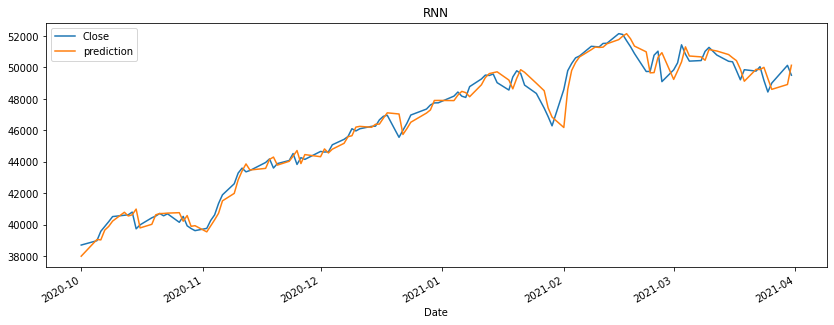

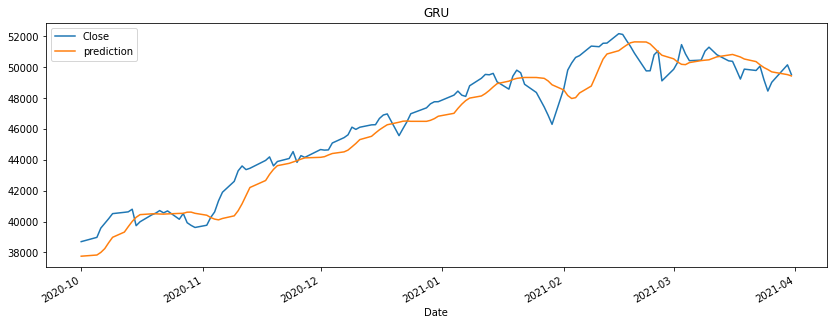

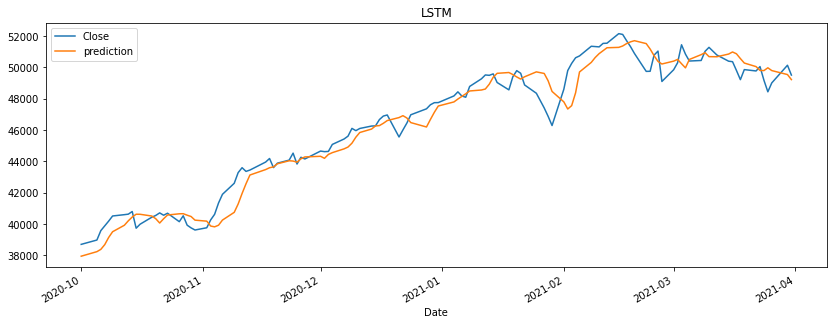

In [ ]:
actual_pred_rnn, error_rnn, rnn_std_mse, rnn_avg_error_perc, _ = actual_pred_plot_no_split(rnn_predictions, 'RNN')
actual_pred_gru, error_gru, gru_std_mse, gru_avg_error_perc, _ = actual_pred_plot_no_split(GRU_predictions, 'GRU')
actual_pred_lstm, error_lstm, lstm_std_mse, lstm_avg_error_perc, _ = actual_pred_plot_no_split(LSTM_predictions, 'LSTM')
print("RNN Error  = ", "{:.12f}".format(error_rnn), "  RNN STD MSE  = ", rnn_std_mse, "  RNN AVG Error =  ", rnn_avg_error_perc)
print("GRU Error  = ", "{:.12f}".format(error_gru), "  GRU STD MSE  = ", gru_std_mse, "  GRU AVG Error =  ", gru_avg_error_perc)
print("LSTM Error = ", "{:.12f}".format(error_lstm),"  LSTM STD MSE = ", lstm_std_mse,"  LSTM AVG Error = ", lstm_avg_error_perc)
#GRU
#5,2 : 4824
#3,2 : 5300
#8,2 : 5430
#10,2: 6250
#5,1 : 5250
#3,1 : 4910
#8,1 : 3950
#10,1: 5600

In [ ]:
combined_predictions_ = pd.DataFrame(columns = ['rnn_prediction', 'gru_prediction', 'lstm_prediction', 'weighted_avg'])
combined_predictions_['rnn_prediction'] = rnn_predictions.reshape(-1)
combined_predictions_['gru_prediction'] = GRU_predictions.reshape(-1,1)
combined_predictions_['lstm_prediction'] = LSTM_predictions.reshape(-1,1)

0.000805206 29.683582864472946 16.09737059397216


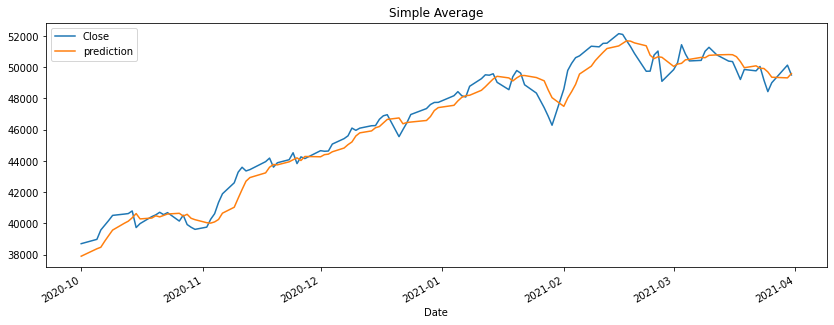

In [ ]:
actual_pred_avg, error_avg, std_mse, avg_error_perc, _ = actual_pred_plot_no_split(combined_predictions_[['rnn_prediction', 'gru_prediction', 'lstm_prediction']].values.mean(axis=1).reshape(-1,1), 'Simple Average')
print(error_avg, std_mse, avg_error_perc)

In [ ]:
sum_of_sq_errors_inv = (1/error_rnn) + (1/error_gru) + (1/error_lstm)
combined_predictions_['weighted_avg'] = ((combined_predictions_['rnn_prediction'].values)*((1/error_rnn)/sum_of_sq_errors_inv))\
                                        + ((combined_predictions_['gru_prediction'].values)*((1/error_gru)/sum_of_sq_errors_inv))\
                                        + ((combined_predictions_['lstm_prediction'].values)*((1/error_lstm)/sum_of_sq_errors_inv))

0.00030862028 34.325963838166736 18.545260968675027


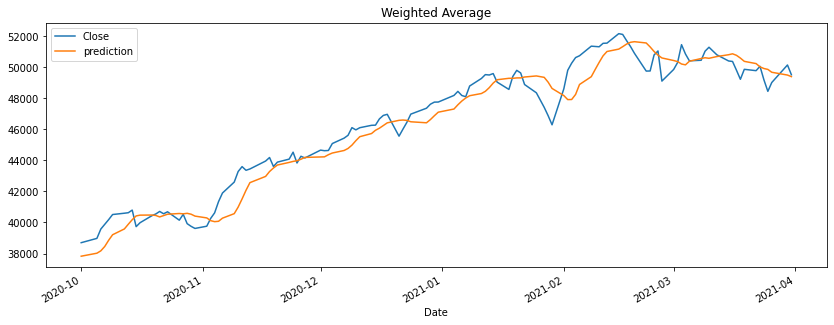

In [ ]:
actual_pred_weighted_avg, error_weighted_avg, std_mse, avg_error_perc, _ = actual_pred_plot_no_split(combined_predictions_['weighted_avg'].values.reshape(-1,1), 'Weighted Average')
print(error_weighted_avg, std_mse, avg_error_perc)

In [ ]:
#train the 3 models using 2010-2017 data and predict values for 2017-2020 using appropriate test data
no_of_inputs_rnn, no_of_outputs_rnn = 20, 1
X_train_1_rnn, y_train_1_rnn, X_test_1_rnn, X_train_2_rnn, y_train_2_rnn, X_test_2_rnn, sc_ts_test_1_rnn, sc_ts_test_2_rnn = ts_train_test(all_data, no_of_inputs_rnn, no_of_outputs_rnn,True)
rnn_model_1, rnn_predictions_1 = rnn_model(X_train_1_rnn, y_train_1_rnn, X_test_1_rnn, sc_ts_test_1_rnn, no_of_outputs_rnn)

no_of_inputs_gru, no_of_outputs_gru = 8, 1
X_train_1_gru, y_train_1_gru, X_test_1_gru, X_train_2_gru, y_train_2_gru, X_test_2_gru, sc_ts_test_1_gru, sc_ts_test_2_gru = ts_train_test(all_data, no_of_inputs_gru, no_of_outputs_gru,True)
GRU_model_1, GRU_predictions_1 = GRU_model_regularization(X_train_1_gru, y_train_1_gru, X_test_1_gru, sc_ts_test_1_gru, no_of_outputs_gru)

no_of_inputs_lstm, no_of_outputs_lstm = 4, 1
X_train_1_lstm, y_train_1_lstm, X_test_1_lstm, X_train_2_lstm, y_train_2_lstm, X_test_2_lstm, sc_ts_test_1_lstm, sc_ts_test_2_lstm = ts_train_test(all_data, no_of_inputs_lstm, no_of_outputs_lstm,True)
LSTM_model_1, LSTM_predictions_1 = LSTM_model_regularization(X_train_1_lstm, y_train_1_lstm, X_test_1_lstm, sc_ts_test_1_lstm, no_of_outputs_lstm)

In [ ]:
combined_predictions_1 = pd.DataFrame(columns = ['rnn_prediction', 'gru_prediction', 'lstm_prediction'])
combined_predictions_1['rnn_prediction'] = rnn_predictions_1.reshape(-1)
combined_predictions_1['gru_prediction'] = GRU_predictions_1.reshape(-1,1)
combined_predictions_1['lstm_prediction'] = LSTM_predictions_1.reshape(-1,1)

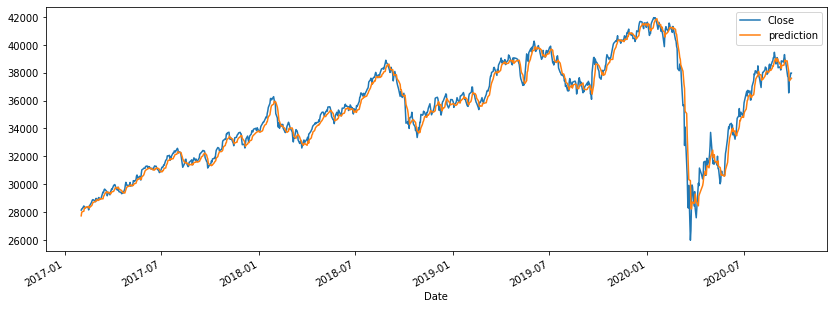

In [ ]:
actual_pred_avg, error_avg, std_mse, avg_error_perc, _ = actual_pred_plot(combined_predictions_1.values.mean(axis=1).reshape(-1,1), True)

In [ ]:
combined_ann = Sequential()
combined_ann.add(Dense(16, input_dim=3, activation='relu')) #3 inputs are predicted values from LSTM, RNN and GRU models
combined_ann.add(Dense(16, activation='relu'))
combined_ann.add(Dense(32, activation='relu'))
combined_ann.add(Dense(1, activation='linear'))
combined_ann.compile(loss='mean_squared_error', optimizer='adam')
combined_ann.summary()

#combined_ann = Sequential()
#combined_ann.add(Dense(16, input_dim=3, activation='relu'))
#combined_ann.add(Dense(32, activation='relu'))
#combined_ann.add(Dense(1, activation='linear'))
#combined_ann.compile(loss='mean_squared_error', optimizer='adam')
#combined_ann.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 16)                64        
_________________________________________________________________
dense_54 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_55 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 33        
Total params: 913
Trainable params: 913
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#train ANN based on x=predicted values from 2017-2020 y=actual values for 2017-2020
combined_ann.fit(x=combined_predictions_1, y=all_data['2017-02':'2020-09']['Close'][0:len(combined_predictions_1)].values, epochs=500, verbose=0)

In [ ]:
#train the previously trained model (on 2010-2017 data), again using 2017-2020 data and predict values for 2020-2021 
# *use the previously trained model and fit more data on it 
rnn_model_2, rnn_predictions_2 = rnn_model(X_train_2_rnn, y_train_2_rnn, X_test_2_rnn, sc_ts_test_2_rnn, no_of_outputs_rnn, rnn_model=rnn_model_1)
GRU_model_2, GRU_predictions_2 = GRU_model_regularization(X_train_2_gru, y_train_2_gru, X_test_2_gru, sc_ts_test_2_gru, no_of_outputs_gru, GRU_model_1)
LSTM_model_2, LSTM_predictions_2 = LSTM_model_regularization(X_train_2_lstm, y_train_2_lstm, X_test_2_lstm, sc_ts_test_2_lstm, no_of_outputs_lstm, LSTM_model_1)

In [ ]:
combined_predictions_2 = pd.DataFrame(columns = ['rnn_prediction', 'gru_prediction', 'lstm_prediction','ann_prediction'])
combined_predictions_2['rnn_prediction'] = rnn_predictions_2.reshape(-1)
combined_predictions_2['gru_prediction'] = GRU_predictions_2.reshape(-1,1)
combined_predictions_2['lstm_prediction'] = LSTM_predictions_2.reshape(-1,1)

In [ ]:
#use predictions for 2020-2021, from the 3 models and input it in the ANN model (trained on 2017-2020 prediction errors) 
#and use the output as final ensemble predicion output
combined_predictions_2['ann_prediction'] = combined_ann.predict(combined_predictions_2[['rnn_prediction', 'gru_prediction', 'lstm_prediction']].values)

0.008995165 57.431295386414526 18.96420089680123


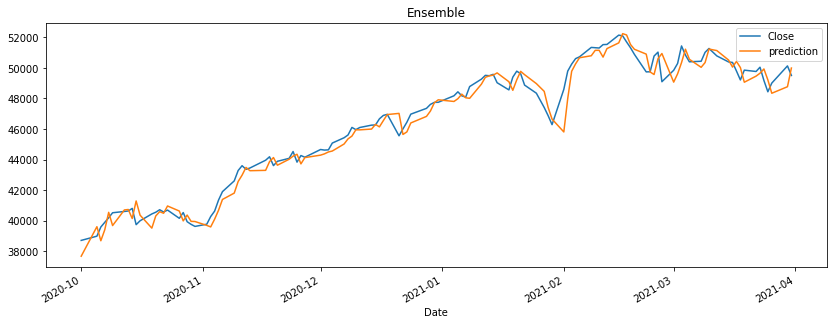

In [ ]:
actual_pred_avg, error_, std_mse, avg_error_perc, _ = actual_pred_plot(combined_predictions_2['ann_prediction'].values.reshape(-1,1), False, title='Ensemble')
print(error_, std_mse, avg_error_perc)